# Post-Training Analysis Notebook

This notebook provides visualizations of RL agent learning trajectories on the GHSOM environment.

## Visualizations

| # | Name | Description | Requires Sequences |
|---|------|-------------|-------------------|
| 1 | State Visitation Heatmap | Shows which clusters agent visits over training phases | ✓ Yes |
| 2 | Hierarchy Navigation | GHSOM layer-wise exploration patterns | ✓ Yes |
| 3 | Reward per Cluster | Which states yield highest rewards | ✓ Yes |
| 4 | Reward Component Evolution | Diversity/structure/transition breakdown | ✗ No |
| 5 | Episode Reward Analysis | Training progress and reward distribution | ✗ No |

## Data Requirements

- **Required:** `config.yaml`, `metrics/reward_components/final_history.json`
- **Optional:** `metrics/comprehensive/episode_sequences.json` (enables visualizations 1-3)

**Note:** `episode_sequences.json` is generated automatically during training with the updated `TianshouComprehensiveMetricsCallback`. If missing, visualizations 1-3 will be skipped gracefully.

## Setup

In [ ]:
import sys
from pathlib import Path
import warnings

# Add parent directory to path
sys.path.insert(0, str(Path.cwd().parent))

from src.utils.post_training import (
    load_training_run,
    plot_state_visitation_heatmap,
    plot_hierarchy_navigation,
    plot_reward_per_cluster,
    plot_reward_component_evolution,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Configure matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 6)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)

## Configuration

**IMPORTANT:** Change `RUN_PATH` to point to your training run directory.

Available benchmark runs:
- `../artifacts/benchmark/20251209_curriculum_learning/cl_enabled/run_drqn_*`
- `../artifacts/training/run_drqn_*`

In [ ]:
# =============================================================================
# 📁 CONFIGURATION: Set the path to your training run
# =============================================================================

# Get workspace root - handles both notebook and script execution
try:
    import IPython
    _notebook_dir = Path(IPython.get_ipython().starting_dir) if hasattr(IPython.get_ipython(), 'starting_dir') else Path.cwd()
except:
    _notebook_dir = Path.cwd()

# Walk up to find workspace root (contains src/, artifacts/)
WORKSPACE_ROOT = _notebook_dir
for _ in range(5):
    if (WORKSPACE_ROOT / "src").exists() and (WORKSPACE_ROOT / "artifacts").exists():
        break
    WORKSPACE_ROOT = WORKSPACE_ROOT.parent
else:
    WORKSPACE_ROOT = Path("/workspace")  # Fallback for container

ARTIFACTS_DIR = WORKSPACE_ROOT / "artifacts"

# =============================================================================
# SET YOUR RUN PATH HERE
# =============================================================================
# Option 1: Specify a specific run path
# RUN_PATH = ARTIFACTS_DIR / "training" / "run_drqn_20251210_114636"

# Option 2: Use the most recent run from artifacts/training/
def find_latest_run(base_dir: Path) -> Path | None:
    """Find the most recent training run directory."""
    runs = []
    for pattern in ["run_*", "*/run_*"]:
        for run_dir in base_dir.glob(pattern):
            if (run_dir / "config.yaml").exists() or (run_dir / "metrics").exists():
                runs.append(run_dir)
    if not runs:
        return None
    return max(runs, key=lambda p: p.stat().st_mtime)

RUN_PATH = find_latest_run(ARTIFACTS_DIR / "training" / "rainbow_cl")

# Validate path exists
if RUN_PATH is None or not RUN_PATH.exists():
    print(f"❌ No valid run found")
    print("\nAvailable training runs:")
    for base_dir in [ARTIFACTS_DIR / "training", ARTIFACTS_DIR / "benchmark"]:
        if base_dir.exists():
            for run_dir in sorted(base_dir.glob("**/run_*")):
                if (run_dir / "config.yaml").exists() or (run_dir / "metrics").exists():
                    # Check for episode_sequences.json
                    has_sequences = (run_dir / "metrics" / "comprehensive" / "episode_sequences.json").exists()
                    seq_indicator = "✓" if has_sequences else "⚠"
                    print(f"  {seq_indicator} {run_dir.relative_to(WORKSPACE_ROOT)}")
    print("\n⚠ = missing episode_sequences.json (run with updated callback to generate)")
else:
    has_sequences = (RUN_PATH / "metrics" / "comprehensive" / "episode_sequences.json").exists()
    print(f"✓ Using run: {RUN_PATH.relative_to(WORKSPACE_ROOT) if WORKSPACE_ROOT in RUN_PATH.parents else RUN_PATH}")
    if not has_sequences:
        print("  ⚠ Note: episode_sequences.json not found - some visualizations will be skipped")
    RUN_PATH = str(RUN_PATH)

AttributeError: 'str' object has no attribute 'glob'

## Load Training Data

In [ ]:
print("Loading training data...")
try:
    data = load_training_run(RUN_PATH, load_ghsom=True)
    
    print(f"\n{'='*50}")
    print(f"Run: {data.run_name}")
    print(f"{'='*50}")
    print(f"Episodes: {data.total_episodes:,}")
    print(f"Timesteps: {data.total_timesteps:,}")
    print(f"Clusters: {data.total_clusters}")
    print(f"Reward components: {list(data.reward_components.keys())}")
    
    # Check for episode sequences
    has_sequences = len(data.episode_sequences) > 0
    print(f"\n📊 Data availability:")
    print(f"  ✓ Episode rewards: {len(data.episode_rewards)} episodes")
    print(f"  ✓ Reward components: {len(data.reward_components)} components")
    if has_sequences:
        print(f"  ✓ Episode sequences: {len(data.episode_sequences)} sequences")
    else:
        print(f"  ⚠ Episode sequences: NOT AVAILABLE")
        print(f"    → Sequence-based visualizations will be skipped")
        print(f"    → To enable: ensure environment exposes `current_sequence` attribute")

except FileNotFoundError as e:
    print(f"❌ Error loading data: {e}")
    print("\nCheck that the run directory contains:")
    print("  - config.yaml")
    print("  - metrics/reward_components/final_history.json")
    data = None
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    import traceback
    traceback.print_exc()
    data = None

Loading training data...

Run: run_rainbow_drqn_20251212_184156
Episodes: 6,249
Timesteps: 100,000
Clusters: 29
Reward components: ['diversity', 'structure', 'transition']

📊 Data availability:
  ✓ Episode rewards: 6249 episodes
  ✓ Reward components: 3 components
  ✓ Episode sequences: 6249 sequences


## Visualization 1: State Visitation Heatmap

Shows which GHSOM clusters the agent visits during different training phases.

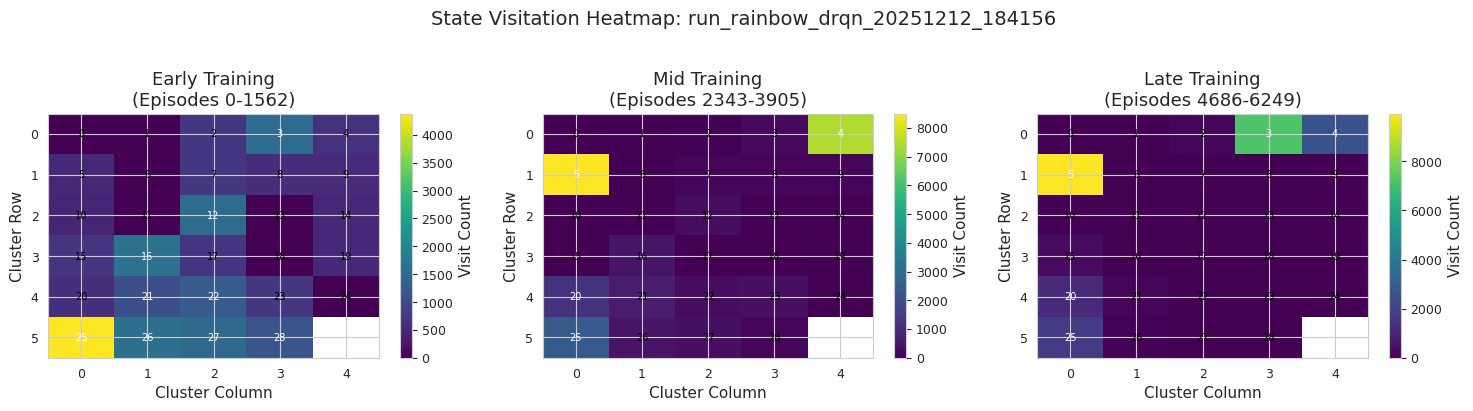

In [ ]:
# Check if sequences are available
if data is not None and len(data.episode_sequences) > 0:
    fig = plot_state_visitation_heatmap(
        data,
        phases=None,  # Auto: early/mid/late
        figsize=(15, 4),
    )
    plt.show()
else:
    print("⚠️ State Visitation Heatmap: SKIPPED")
    print("   Requires episode_sequences.json which is not available for this run.")
    print("   To enable: ensure environment exposes `current_sequence` attribute during training.")

## Visualization 2: Hierarchy Navigation

Shows how the agent navigates the GHSOM hierarchy layers.

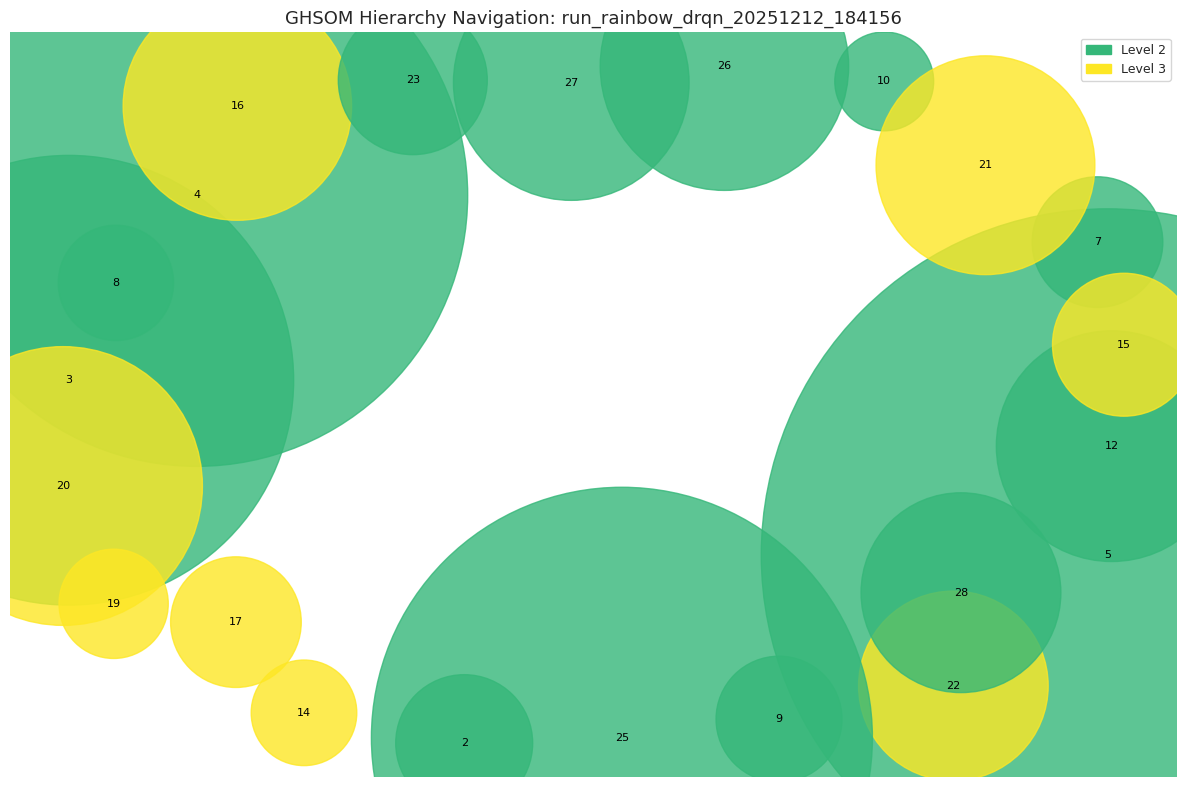

In [ ]:
# Check if sequences are available
if data is not None and len(data.episode_sequences) > 0:
    fig = plot_hierarchy_navigation(
        data,
        max_depth=3,
        min_visits=10,
        figsize=(12, 8),
    )
    plt.show()
else:
    print("⚠️ Hierarchy Navigation: SKIPPED")
    print("   Requires episode_sequences.json which is not available for this run.")

## Visualization 3: Reward per Cluster

Shows which clusters (states) yield the highest rewards.

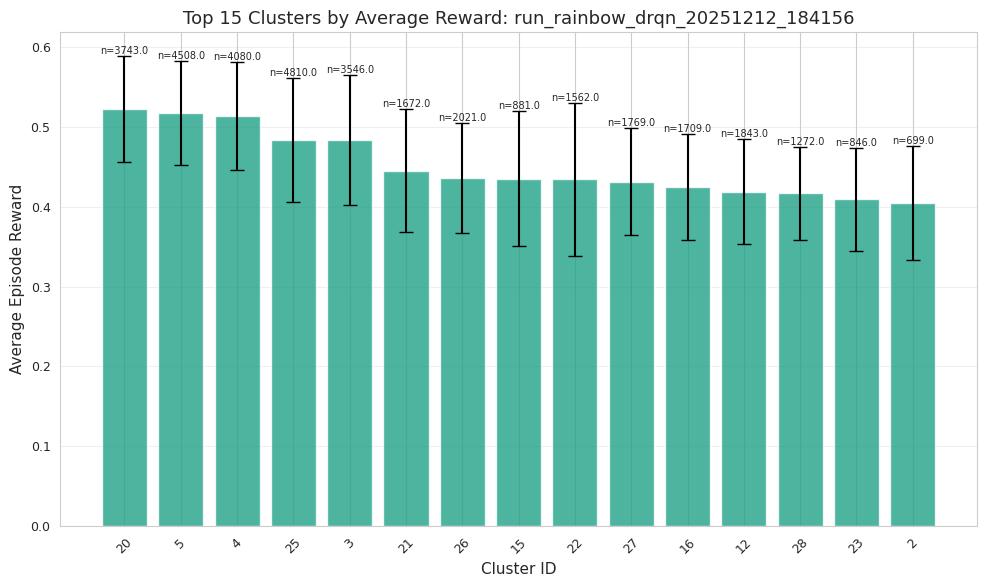

In [ ]:
# Check if sequences are available
if data is not None and len(data.episode_sequences) > 0:
    fig = plot_reward_per_cluster(
        data,
        top_k=15,
        figsize=(10, 6),
    )
    plt.show()
else:
    print("⚠️ Reward per Cluster: SKIPPED")
    print("   Requires episode_sequences.json which is not available for this run.")

## Visualization 4: Reward Component Evolution

Shows how reward components (diversity, structure, transition) evolve during training.

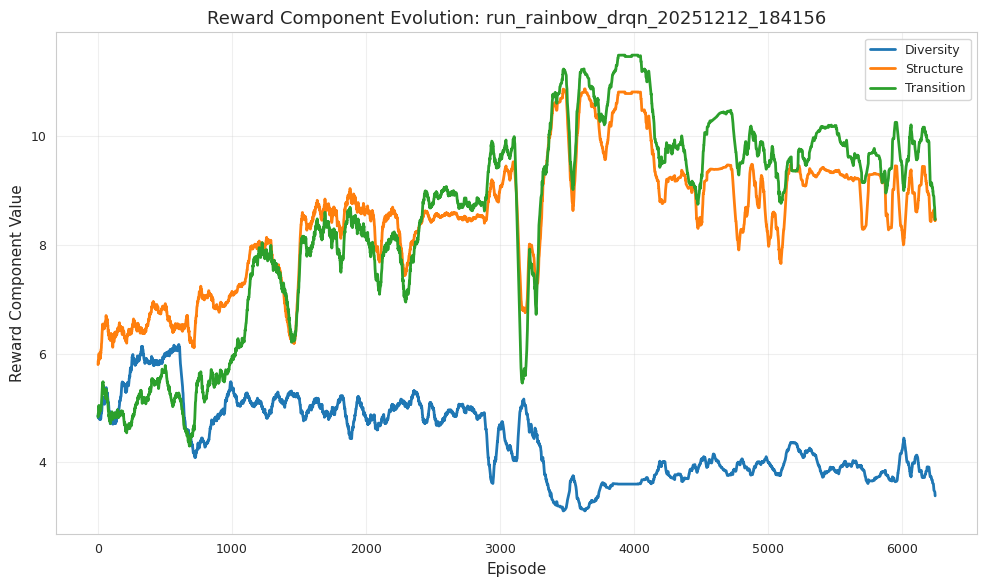

In [ ]:
# Reward Component Evolution - works with reward_components (no sequences needed)
if data is not None and len(data.reward_components) > 0:
    fig = plot_reward_component_evolution(
        data,
        window_size=50,
        figsize=(10, 6),
    )
    plt.show()
else:
    print("⚠️ Reward Component Evolution: SKIPPED")
    print("   Requires reward component history which is not available for this run.")

## Visualization 5: Episode Reward Analysis

Shows episode rewards over time with rolling statistics. Works without episode sequences.

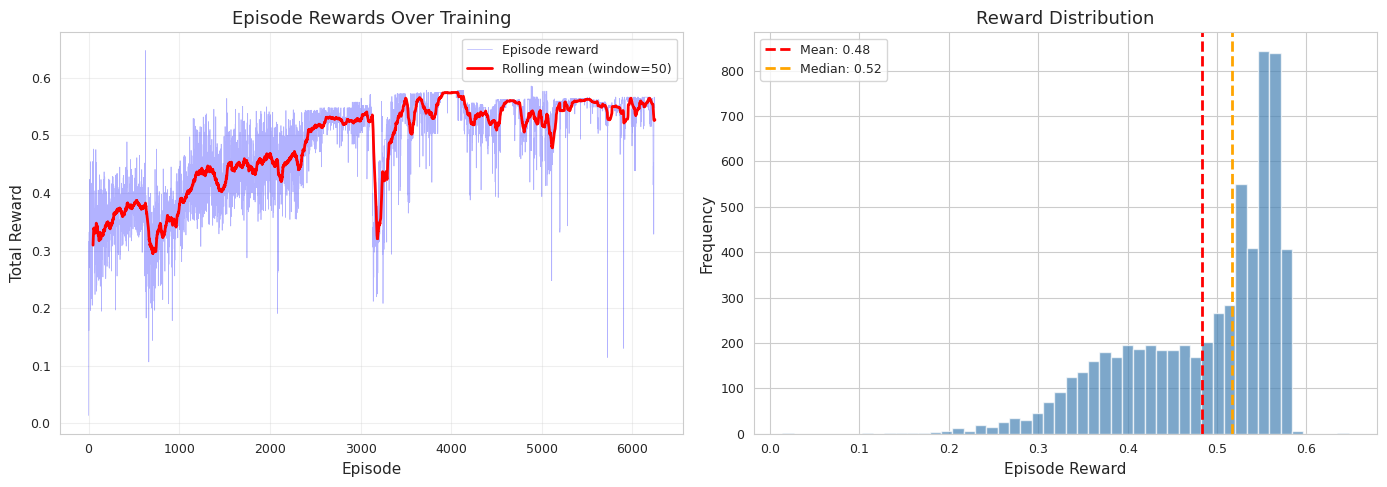


📊 Episode Reward Statistics:
   Episodes: 6,249
   Mean: 0.4835
   Std: 0.0848
   Min: 0.0139
   Max: 0.6473
   Last 100 mean: 0.5442


In [ ]:
# Episode Reward Analysis - always works if data is available
if data is not None and len(data.episode_rewards) > 0:
    rewards = np.array(data.episode_rewards)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Episode rewards with rolling mean
    ax1 = axes[0]
    ax1.plot(rewards, alpha=0.3, color='blue', linewidth=0.5, label='Episode reward')
    window = min(50, len(rewards) // 10)
    if window > 1:
        rolling_mean = pd.Series(rewards).rolling(window).mean()
        ax1.plot(rolling_mean, color='red', linewidth=2, label=f'Rolling mean (window={window})')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Episode Rewards Over Training')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Right: Reward distribution
    ax2 = axes[1]
    ax2.hist(rewards, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
    ax2.axvline(rewards.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {rewards.mean():.2f}')
    ax2.axvline(np.median(rewards), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(rewards):.2f}')
    ax2.set_xlabel('Episode Reward')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Reward Distribution')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Statistics summary
    print(f"\n📊 Episode Reward Statistics:")
    print(f"   Episodes: {len(rewards):,}")
    print(f"   Mean: {rewards.mean():.4f}")
    print(f"   Std: {rewards.std():.4f}")
    print(f"   Min: {rewards.min():.4f}")
    print(f"   Max: {rewards.max():.4f}")
    print(f"   Last 100 mean: {rewards[-100:].mean():.4f}" if len(rewards) >= 100 else "")
else:
    print("⚠️ Episode Reward Analysis: SKIPPED")
    print("   No episode rewards available.")

## Export Figures (Optional)

Save all visualizations as high-resolution PNG files.

In [ ]:
if data is None:
    print("❌ No data loaded - cannot export figures")
else:
    # Create output directory (using WORKSPACE_ROOT from config cell)
    output_dir = WORKSPACE_ROOT / "outputs" / "post_training" / data.run_name
    output_dir.mkdir(parents=True, exist_ok=True)

    # Generate and save visualizations based on available data
    print("Exporting visualizations...")
    has_sequences = len(data.episode_sequences) > 0
    exported = 0
    
    # Sequence-dependent visualizations
    if has_sequences:
        try:
            plot_state_visitation_heatmap(
                data, 
                save_path=output_dir / "visitation_heatmap.png"
            )
            plt.close()
            print("  ✓ visitation_heatmap.png")
            exported += 1
        except Exception as e:
            print(f"  ✗ visitation_heatmap.png: {e}")

        try:
            plot_hierarchy_navigation(
                data, 
                save_path=output_dir / "hierarchy_navigation.png"
            )
            plt.close()
            print("  ✓ hierarchy_navigation.png")
            exported += 1
        except Exception as e:
            print(f"  ✗ hierarchy_navigation.png: {e}")

        try:
            plot_reward_per_cluster(
                data, 
                save_path=output_dir / "reward_per_cluster.png"
            )
            plt.close()
            print("  ✓ reward_per_cluster.png")
            exported += 1
        except Exception as e:
            print(f"  ✗ reward_per_cluster.png: {e}")
    else:
        print("  ⚠ Skipping sequence-based plots (visitation_heatmap, hierarchy_navigation, reward_per_cluster)")
    
    # Reward component evolution (no sequences needed)
    if len(data.reward_components) > 0:
        try:
            plot_reward_component_evolution(
                data, 
                save_path=output_dir / "component_evolution.png"
            )
            plt.close()
            print("  ✓ component_evolution.png")
            exported += 1
        except Exception as e:
            print(f"  ✗ component_evolution.png: {e}")
    
    # Episode reward analysis (no sequences needed)
    if len(data.episode_rewards) > 0:
        try:
            rewards = np.array(data.episode_rewards)
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            ax1 = axes[0]
            ax1.plot(rewards, alpha=0.3, color='blue', linewidth=0.5, label='Episode reward')
            window = min(50, max(1, len(rewards) // 10))
            if window > 1:
                rolling_mean = pd.Series(rewards).rolling(window).mean()
                ax1.plot(rolling_mean, color='red', linewidth=2, label=f'Rolling mean (w={window})')
            ax1.set_xlabel('Episode')
            ax1.set_ylabel('Total Reward')
            ax1.set_title('Episode Rewards Over Training')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            ax2 = axes[1]
            ax2.hist(rewards, bins=min(50, len(rewards)), color='steelblue', edgecolor='white', alpha=0.7)
            ax2.axvline(rewards.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {rewards.mean():.2f}')
            ax2.axvline(np.median(rewards), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(rewards):.2f}')
            ax2.set_xlabel('Episode Reward')
            ax2.set_ylabel('Frequency')
            ax2.set_title('Reward Distribution')
            ax2.legend()
            
            plt.tight_layout()
            plt.savefig(output_dir / "episode_rewards.png", dpi=150, bbox_inches='tight')
            plt.close()
            print("  ✓ episode_rewards.png")
            exported += 1
        except Exception as e:
            print(f"  ✗ episode_rewards.png: {e}")
    
    print(f"\n✅ Exported {exported} figure(s) to: {output_dir}")

Exporting visualizations...
  ✓ visitation_heatmap.png
  ✓ hierarchy_navigation.png
  ✓ reward_per_cluster.png
  ✓ component_evolution.png
  ✓ episode_rewards.png

✅ Exported 5 figure(s) to: /workspace/outputs/post_training/run_rainbow_drqn_20251212_184156
